Step 5: Action=right, Position=(4, 1)


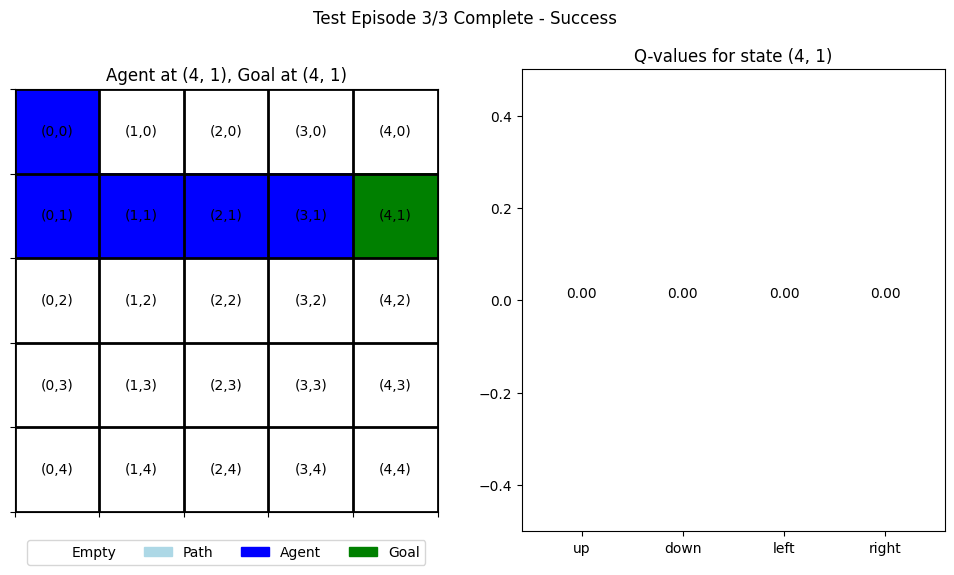

Result: Goal reached!
Steps: 5, Total Reward: 9.60


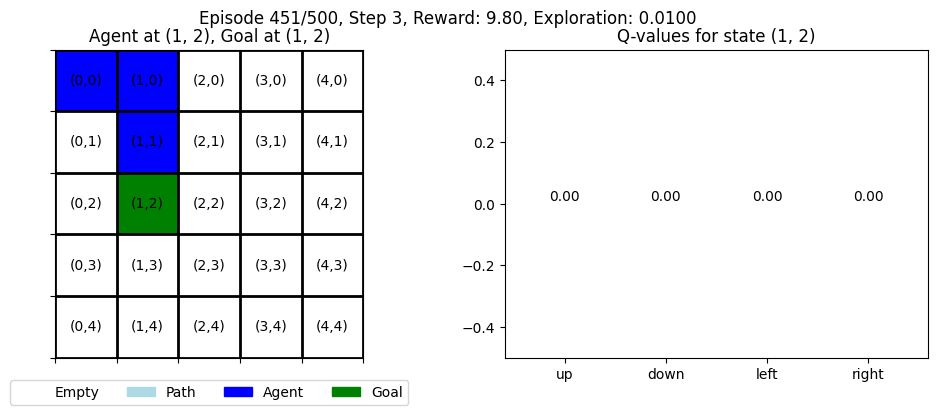

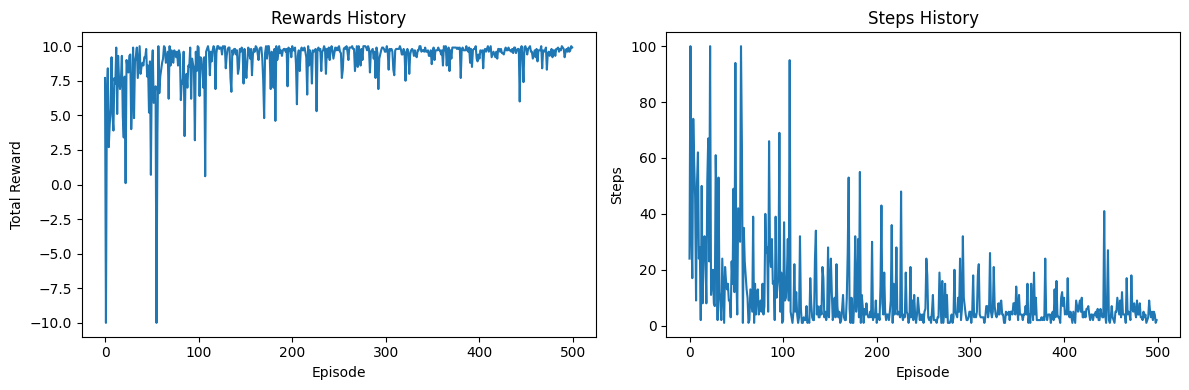

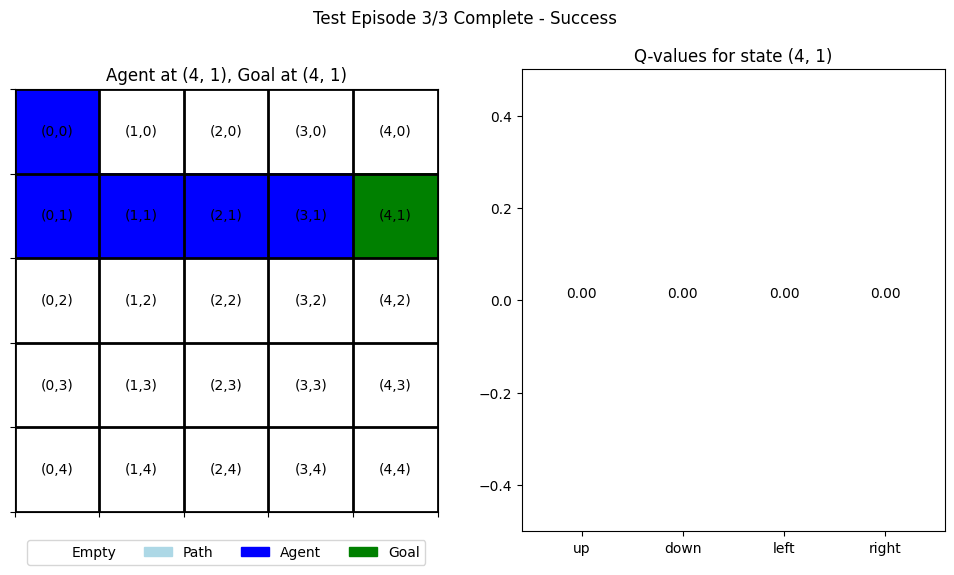

In [4]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output, display
from typing import List, Dict, Any, Tuple

class Environment:
    """A simple environment the agent can interact with."""

    def __init__(self):
        # Simple grid environment (5x5)
        self.grid_size = 5
        self.agent_position = (0, 0)
        # Place a goal randomly on the grid
        self.goal_position = (random.randint(0, self.grid_size-1),
                             random.randint(0, self.grid_size-1))
        # Make sure goal isn't at the starting position
        while self.goal_position == self.agent_position:
            self.goal_position = (random.randint(0, self.grid_size-1),
                                 random.randint(0, self.grid_size-1))
        # Keep track of path
        self.path = [self.agent_position]

    def get_state(self) -> Dict[str, Any]:
        """Return the current state of the environment."""
        return {
            'agent_position': self.agent_position,
            'goal_position': self.goal_position,
            'distance_to_goal': self._calculate_distance()
        }

    def _calculate_distance(self) -> float:
        """Calculate Manhattan distance to goal."""
        x1, y1 = self.agent_position
        x2, y2 = self.goal_position
        return abs(x1 - x2) + abs(y1 - y2)

    def take_action(self, action: str) -> Tuple[Dict[str, Any], float, bool]:
        """
        Process the agent's action and return new state, reward, and whether goal is reached.

        Actions: 'up', 'down', 'left', 'right'
        """
        x, y = self.agent_position

        # Move according to action
        if action == 'up' and y < self.grid_size - 1:
            y += 1
        elif action == 'down' and y > 0:
            y -= 1
        elif action == 'right' and x < self.grid_size - 1:
            x += 1
        elif action == 'left' and x > 0:
            x -= 1

        # Update position
        self.agent_position = (x, y)
        # Add to path
        self.path.append(self.agent_position)

        # Check if reached goal
        goal_reached = self.agent_position == self.goal_position

        # Calculate reward
        old_distance = self._calculate_distance()
        if goal_reached:
            reward = 10.0  # High reward for reaching goal
        else:
            # Small negative reward for each step (encourages shorter paths)
            reward = -0.1

        # Return new state, reward, and whether goal is reached
        return self.get_state(), reward, goal_reached

    def reset(self):
        """Reset environment to initial state."""
        self.agent_position = (0, 0)
        self.goal_position = (random.randint(0, self.grid_size-1),
                             random.randint(0, self.grid_size-1))
        while self.goal_position == self.agent_position:
            self.goal_position = (random.randint(0, self.grid_size-1),
                                 random.randint(0, self.grid_size-1))
        # Reset path
        self.path = [self.agent_position]
        return self.get_state()

    def render(self, fig=None, axes=None, show_path=True):
        """Visualize the current state of the environment."""
        if fig is None or axes is None:
            fig, axes = plt.subplots(figsize=(6, 6))

        # Create grid
        grid = np.zeros((self.grid_size, self.grid_size))

        # Mark goal
        gx, gy = self.goal_position
        grid[gy, gx] = 3  # Goal cell

        # Mark agent
        ax, ay = self.agent_position
        grid[ay, ax] = 2  # Agent cell

        # Mark path if required
        if show_path and len(self.path) > 1:
            for x, y in self.path[:-1]:  # Exclude current position
                grid[y, x] = 1  # Path cell

        # Create colormap
        cmap = ListedColormap(['white', 'lightblue', 'blue', 'green'])

        # Plot grid
        axes.imshow(grid, cmap=cmap)

        # Add gridlines
        axes.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        axes.set_xticks(np.arange(-.5, self.grid_size, 1))
        axes.set_yticks(np.arange(-.5, self.grid_size, 1))
        axes.set_xticklabels([])
        axes.set_yticklabels([])

        # Add coordinates
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                axes.text(j, i, f'({j},{i})', ha='center', va='center')

        # Add legend
        legend_elements = [
            plt.Rectangle((0, 0), 1, 1, color='white', label='Empty'),
            plt.Rectangle((0, 0), 1, 1, color='lightblue', label='Path'),
            plt.Rectangle((0, 0), 1, 1, color='blue', label='Agent'),
            plt.Rectangle((0, 0), 1, 1, color='green', label='Goal')
        ]
        axes.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

        axes.set_title(f'Agent at {self.agent_position}, Goal at {self.goal_position}')

        return fig, axes


class QAgent:
    """A reinforcement learning agent using Q-learning."""

    def __init__(self, actions: List[str], learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0):
        self.actions = actions
        self.learning_rate = learning_rate  # Alpha
        self.discount_factor = discount_factor  # Gamma
        self.exploration_rate = exploration_rate  # Epsilon
        self.exploration_decay = 0.995  # Decay rate for exploration
        self.q_table = {}  # Q-table for storing state-action values

    def get_state_key(self, state: Dict[str, Any]) -> str:
        """Convert state dictionary to a string key for Q-table."""
        return f"{state['agent_position']}_{state['goal_position']}"

    def get_action(self, state: Dict[str, Any]) -> str:
        """
        Choose an action using epsilon-greedy policy.
        With probability epsilon, choose randomly, otherwise choose best action.
        """
        state_key = self.get_state_key(state)

        # Initialize Q-values for this state if not seen before
        if state_key not in self.q_table:
            self.q_table[state_key] = {action: 0.0 for action in self.actions}

        # Exploration: random action
        if random.random() < self.exploration_rate:
            return random.choice(self.actions)
        # Exploitation: best action based on Q-values
        else:
            # In case of ties, randomly select among actions with max Q-value
            max_q = max(self.q_table[state_key].values())
            best_actions = [action for action, q_value in self.q_table[state_key].items()
                           if q_value == max_q]
            return random.choice(best_actions)

    def learn(self, state: Dict[str, Any], action: str, reward: float,
              next_state: Dict[str, Any]) -> None:
        """Update Q-values using the Q-learning update rule."""
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        # Initialize Q-values for next state if not seen before
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = {action: 0.0 for action in self.actions}

        # Current Q-value
        current_q = self.q_table[state_key][action]

        # Maximum Q-value for next state
        max_next_q = max(self.q_table[next_state_key].values())

        # Q-learning update rule
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q - current_q)

        # Update Q-value
        self.q_table[state_key][action] = new_q

        # Decay exploration rate
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(0.01, self.exploration_rate)  # Minimum exploration

    def visualize_q_values(self, state: Dict[str, Any], fig=None, axes=None):
        """Visualize Q-values for the current state."""
        if fig is None or axes is None:
            fig, axes = plt.subplots(figsize=(8, 2))

        state_key = self.get_state_key(state)

        # Initialize Q-values for this state if not seen before
        if state_key not in self.q_table:
            self.q_table[state_key] = {action: 0.0 for action in self.actions}

        # Get Q-values for this state
        q_values = self.q_table[state_key]

        # Plot Q-values
        bars = axes.bar(q_values.keys(), q_values.values())

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            axes.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

        axes.set_title(f'Q-values for state {state["agent_position"]}')
        axes.set_ylim(bottom=min(min(q_values.values())-0.5, -0.5), top=max(max(q_values.values())+0.5, 0.5))

        return fig, axes


# Training function with visualization
def train_agent(episodes=1000, visualize=True, visualize_every=100, delay=0.5, verbose=True):
    env = Environment()
    agent = QAgent(actions=['up', 'down', 'left', 'right'])

    rewards_history = []
    steps_history = []

    if visualize:
        fig_env = plt.figure(figsize=(12, 4))
        ax_env = fig_env.add_subplot(1, 2, 1)
        ax_q = fig_env.add_subplot(1, 2, 2)

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < 100:  # Prevent infinite loops
            # Choose action
            action = agent.get_action(state)

            # Take action
            next_state, reward, done = env.take_action(action)

            # Learn from experience
            agent.learn(state, action, reward, next_state)

            state = next_state
            total_reward += reward
            steps += 1

            # Visualize if required
            if visualize and (episode % visualize_every == 0 or episodes < 10):
                clear_output(wait=True)

                ax_env.clear()
                ax_q.clear()

                env.render(fig_env, ax_env)
                agent.visualize_q_values(state, fig_env, ax_q)

                plt.suptitle(f'Episode {episode+1}/{episodes}, Step {steps}, Reward: {total_reward:.2f}, Exploration: {agent.exploration_rate:.4f}')
                display(fig_env)

                if done:
                    print(f"Goal reached! Steps: {steps}")

                time.sleep(delay)

        rewards_history.append(total_reward)
        steps_history.append(steps)

        if verbose and episode % 100 == 0:
            print(f"Episode {episode}/{episodes}, Total Reward: {total_reward:.2f}, "
                  f"Steps: {steps}, Exploration Rate: {agent.exploration_rate:.4f}")

    # Final visualization
    if visualize:
        fig_history, (ax_rewards, ax_steps) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot rewards history
        ax_rewards.plot(rewards_history)
        ax_rewards.set_title('Rewards History')
        ax_rewards.set_xlabel('Episode')
        ax_rewards.set_ylabel('Total Reward')

        # Plot steps history
        ax_steps.plot(steps_history)
        ax_steps.set_title('Steps History')
        ax_steps.set_xlabel('Episode')
        ax_steps.set_ylabel('Steps')

        plt.tight_layout()
        display(fig_history)

    return agent, env, rewards_history, steps_history

# Test the trained agent with visualization
def test_agent(agent, env, episodes=10, delay=0.5):
    print("\nTesting the trained agent:")

    fig = plt.figure(figsize=(12, 6))
    ax_grid = fig.add_subplot(1, 2, 1)
    ax_q = fig.add_subplot(1, 2, 2)

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0

        print(f"\nEpisode {episode+1}:")
        print(f"Start: {state['agent_position']}, Goal: {state['goal_position']}")

        while not done and steps < 100:  # Prevent infinite loops
            # Clear the plot
            ax_grid.clear()
            ax_q.clear()

            # Render the environment
            env.render(fig, ax_grid)

            # Choose best action (no exploration)
            state_key = agent.get_state_key(state)

            # Initialize if needed
            if state_key not in agent.q_table:
                agent.q_table[state_key] = {action: 0.0 for action in agent.actions}

            # Get best action
            action = max(agent.q_table[state_key].items(), key=lambda x: x[1])[0]

            # Visualize Q-values
            agent.visualize_q_values(state, fig, ax_q)

            plt.suptitle(f'Test Episode {episode+1}/{episodes}, Step {steps+1}')
            display(fig)
            clear_output(wait=True)

            # Take action
            next_state, reward, done = env.take_action(action)

            print(f"Step {steps+1}: Action={action}, Position={next_state['agent_position']}")

            state = next_state
            total_reward += reward
            steps += 1

            time.sleep(delay)

        # Final render
        ax_grid.clear()
        ax_q.clear()
        env.render(fig, ax_grid)
        agent.visualize_q_values(state, fig, ax_q)
        plt.suptitle(f'Test Episode {episode+1}/{episodes} Complete - {"Success" if done else "Failed"}')
        display(fig)

        print(f"Result: {'Goal reached!' if done else 'Failed to reach goal'}")
        print(f"Steps: {steps}, Total Reward: {total_reward:.2f}")
        time.sleep(delay * 2)

# Function to run in Google Colab
def run_in_colab(training_episodes=1000, visualize_training=True,
                 visualize_every=100, training_delay=0.1,
                 test_episodes=5, test_delay=0.5):
    """
    Run the full Q-learning demonstration in Google Colab

    Parameters:
    - training_episodes: Number of episodes for training
    - visualize_training: Whether to visualize during training
    - visualize_every: How often to visualize during training (every N episodes)
    - training_delay: Delay between visualization updates during training (seconds)
    - test_episodes: Number of episodes for testing
    - test_delay: Delay between steps during testing (seconds)
    """
    print("Training Q-learning agent...")
    agent, env, rewards, steps = train_agent(
        episodes=training_episodes,
        visualize=visualize_training,
        visualize_every=visualize_every,
        delay=training_delay
    )

    print("\nTraining complete! Now testing the agent...")
    test_agent(agent, env, episodes=test_episodes, delay=test_delay)

    return agent, env, rewards, steps

# Run the code in Google Colab
if __name__ == "__main__":
    # For quick demonstration
    run_in_colab(training_episodes=500, visualize_every=50, training_delay=0.05, test_episodes=3)

    # For more detailed learning process, uncomment this instead:
    # run_in_colab(training_episodes=1000, visualize_every=20, training_delay=0.1, test_episodes=5)